# 목차

1. 데이터셋 구축  
  a. 삼성전자 주가 데이터  
  b. 보조지표  
  c. 투자자별 매매동향  
  d. 뉴스기사 감성분석
2. 시각화  
3. 모델 훈련  
4. 성능 비교  

# 데이터셋 구축

## 1. 삼성전자 주가 데이터



In [1]:
!pip install finance-datareader
!pip install ta

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.0/89.0 kB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=60f2327ffaf33442e202043115dc267d36cbae8e03e6f44ae1d239c6406750d3
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [2]:
import pandas as pd
import numpy as np
import FinanceDataReader as fdr
import ta
import tensorflow as tf

# 삼성전자 주가 데이터 불러오기
df = fdr.DataReader('005930','2014-10-01', '2024-08-28')

In [3]:
# 변동성
df['Volatility'] = df['Close'].rolling(window=20).std()

# CHANGE 변수 삭제
df = df.drop('Change', axis=1)

## 2. 보조지표

### 1. 볼린저밴드  

**사용하는 기술 지표: %B, 밴드폭**
- %B: 볼린저 밴드 상에서 주가가 어느 위치에 있는지를 나타낸 지표
- 밴드폭: 볼린저밴드의 폭

In [4]:
# 2번째 데이터셋 정의
df2 = df.copy().drop(columns=['Open','High','Low','Close','Volume','Volatility'])

# 볼린저밴드
bollinger_band = ta.volatility.BollingerBands(close=df['Close'], window=20, fillna=False)

df2['PB'] = bollinger_band.bollinger_pband()        # %B
df2['BandWidth'] = bollinger_band.bollinger_wband() # 밴드폭

### 2. DMI, ADX  

주가가 어떤 방향의 추세로 움직이고 있는지를 판단하고 그 추세의 강도를 측정하기 위해 사용되는 지표  
**사용하는 기술 지표: +DI, -DI, ADX**
- +DI: 주가의 상승 강도
- -DI: 주가의 하락 강도
- ADX: 주가의 변동 추세의 강도

#### 계산식  
- +DM: (당일 고가>전일 고가)이면서 (고가의 변동폭>저가의 변동폭)일 경우, (당일 고가-전일 고가)의 절댓값, 이외에는 0
- -DM: (당일 저가<전일 저가)이면서 (고가의 변동폭<저가의 변동폭)일 경우, (당일 저가-전일 저가)의 절댓값, 이외에는 0

In [5]:
# pdiff = 당일 고가-전일 고가, mdiff = 당일 저가-전일 저가
high_diff, low_diff = df['High'].diff(1), df['Low'].diff(1)

plus_dm = pd.Series(np.where((high_diff > 0) & (high_diff > -low_diff), high_diff, 0), index=df.index)   # +DM
minus_dm = pd.Series(np.where((-low_diff > 0) & (-low_diff > high_diff), -low_diff, 0), index=df.index)   # -DM

- TR = max{(당일 고가-당일 저가), (당일 고가-전일 종가)의 절댓값, (당일 저가-전일 종가)의 절댓값}

In [6]:
# 최댓값을 비교하기 위해 각각의 값을 계산하여 입력하기 위한 데이터프레임 정의
tr_df = pd.DataFrame()

# 각 조건에 해당하는 값을 계산하여 입력
tr_df['Condition 1'] = df['High'] - df['Low']
tr_df['Condition 2'] = (df['High'] - df['Close'].shift(-1)).abs()
tr_df['Condition 3'] = (df['Low'] - df['Close'].shift(-1)).abs()

# 각 행으로부터 최댓값 산출하여 TR을 series로 반환
tr = tr_df.max(axis = 1)


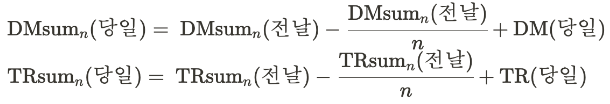

In [7]:
# +DM_sum, -DM_sum, TR_sum을 계산하는 함수 정의
def sum_index(df,series):
    # 빈 시리즈 정의
    sum = pd.Series(np.nan, index=df.index)
    # 14일 동안의 DM 또는 TR 합을 계산하여 초항으로 입력
    sum.iloc[13] = series[0:14].sum()
    for i in range(14,len(df)):
        # 위의 계산식에 따라 DM_sum 또는 TR_sum을 계산하여 입력
        sum.iloc[i] = sum.iloc[i-1] - sum.iloc[i-1]/14 + series.iloc[i]
    return sum

# +DM_sum, -DM_sum, TR_sum
plus_dm_sum, minus_dm_sum, tr_sum = sum_index(df,plus_dm), sum_index(df,minus_dm), sum_index(df,tr)

- +DI = +DMN/TRN*100
- -DI = -DMN/TRN*100

In [8]:
# +DI, -DI를 데이터프레임에 추가
df2['PDI'], df2['MDI'] = plus_dm_sum/tr_sum*100, minus_dm_sum/tr_sum*100

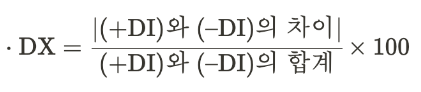

In [9]:
# 위의 계산식에 따라 DX 계산
dx = ((df2['PDI']-df2['MDI']).abs()) / (df2['PDI']+df2['MDI']) * 100

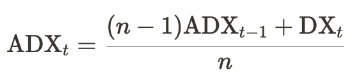

In [10]:
# ADX를 입력하기 위한 빈 series 선언
adx = pd.Series(np.nan, index=df.index)

# 14일 동안의 DX의 평균을 계산하여 ADX의 초항으로 입력
adx.iloc[26] = dx[13:27].mean()

# 위의 계산식에 따라 ADX 계산
for i in range(27,len(df2)):
    adx.iloc[i] = (adx.iloc[i-1]*13 + dx.iloc[i])/14

# ADX를 데이터프레임에 추가
df2['ADX'] = adx

### 3. WMA (이동평균선)  

- WMA_short: 단기 이동평균선 (5일)
- WMA_long: 장기 이동평균선 (20일)

In [11]:
df2['WMA_short'] = ta.trend.WMAIndicator(close=df['Close'], window=5, fillna=False).wma()
df2['WMA_long'] = ta.trend.WMAIndicator(close=df['Close'], window=20, fillna=False).wma()

### 4. MACD  

- MACD: 주가 흐름의 추세를 확인하고 추세의 강도와 지속성을 파악하는데 활용되는 지표
- MACD_sig: MACD의 지수이동평균 (9일)

In [12]:
df2['MACD'] = ta.trend.macd(close=df['Close'], window_slow=26, window_fast=12, fillna=False)
df2['MACD_sig'] = ta.trend.macd_signal(close=df['Close'], window_slow=26, window_fast=12, window_sign=9, fillna=False)

### 5. RSI  

- RSI: 주가의 평균 상승폭과 하락폭을 비교하여 가격의 상승 압력과 하락 압력 간 상대적인 강도를 나타내는 기술적 지표
- RSI_sig: RSI의 단순이동평균(9일)

In [13]:
df2['RSI'] = ta.momentum.rsi(close=df['Close'], window=14, fillna=False)
df2['RSI_sig'] = df2['RSI'].rolling(9).mean()

### 6. Stochastic Fast  

일정 기간 동안 최고가와 최저가의 범위 중 현재 가격의 위치를 백분율로 나타내는 지표  
- %K: 최고가와 최저가의 범위 중 현재 가격의 위치를 백분율로 나타낸 값
- %D: %K의 이동평균

In [14]:
df2['%K'] = ta.momentum.stoch(high=df['High'], low=df['Low'], close=df['Close'], window=14, smooth_window=3, fillna=False)
df2['%D'] = ta.momentum.stoch_signal(high=df['High'], low=df['Low'], close=df['Close'], window=14, smooth_window=3, fillna=False)

In [15]:
# 2015년 1월 2일부터 시작하도록 데이터프레임 자르기
df = df[62:]

# 데이터 확인
df.tail()

,Open,High,Low,Close,Volume,Volatility
Date,,,,,,
2024-08-22,78700,78900,77800,78300,8149101,3478.898797
2024-08-23,77700,78400,77500,77700,9420306,3432.119953
2024-08-26,78100,78200,76000,76100,15655938,3374.591593
2024-08-27,75700,76500,75600,75800,11130145,3286.699672
2024-08-28,75800,76400,75400,76400,9671798,3175.809056


In [16]:
# 2015년 1월 2일부터 시작하도록 데이터프레임 자르기
df2 = df2[62:]

# 데이터 확인
df2.tail()

,PB,BandWidth,PDI,MDI,ADX,WMA_short,WMA_long,MACD,MACD_sig,RSI,RSI_sig,%K,%D
Date,,,,,,,,,,,,,
2024-08-22,0.523593,17.393235,23.690890,26.885275,17.296170,78546.666667,77393.809524,-1000.619600,-1378.437514,48.042565,45.810153,72.321429,59.327269
2024-08-23,0.489164,17.189115,22.105095,25.958748,16.633428,78180.000000,77367.142857,-946.960787,-1292.142169,46.517586,46.705418,75.000000,66.088275
2024-08-26,0.385609,16.953263,20.558670,28.515095,16.603411,77446.666667,77200.952381,-1021.764158,-1238.066567,42.631423,46.931899,48.101266,65.140898
2024-08-27,0.380208,16.569360,19.993801,28.952769,16.724851,76760.000000,77029.047619,-1092.658375,-1208.984928,41.924203,46.900053,42.857143,55.319470
2024-08-28,0.443061,16.058081,19.357385,28.667796,16.914970,76480.000000,76940.000000,-1087.887083,-1184.765359,43.927696,46.763210,50.649351,47.202586


## 3. 투자자별 매매동향

In [17]:
# 3번째 데이터셋 정의
df3 = pd.read_csv('/content/sample_data/투자자별 매매동향(삼성전자).csv')

# 과거부터 현재 순서로 정렬해주기
df3 = df3.iloc[::-1].reset_index(drop=True)

# '기관 순매매량', '외국인 순매매량', '외국인 보유주수', '외국인 보유율' 열만 가져오기
df3 = pd.concat([df3.iloc[:len(df3)-1,0],df3.iloc[:len(df3)-1,5:]],axis=1)
df3.columns = ['날짜','기관 순매매량', '외국인 순매매량', '외국인 보유주수', '외국인 보유율']

In [18]:
# 2015년 1월 2일의 인덱스 확인
df3[df3['날짜'] == '2015.01.02']

,날짜,기관 순매매량,외국인 순매매량,외국인 보유주수,외국인 보유율
2482,2015.01.02,"-20,583","21,328","76,336,351",51.82%


In [19]:
# 2015년 1월 2일부터 시작하도록 데이터프레임 자르기
df3 = df3[2482:].drop(columns=['날짜'])

# 날짜 인덱스 가져오기
df3.index = fdr.DataReader('005930','2015-01-02', '2024-08-28').index

In [20]:
# 각 셀의 데이터 타입을 숫자로 변환
df3['기관 순매매량'] = df3['기관 순매매량'].apply(lambda x: int(x.replace(",", "")))
df3['외국인 순매매량'] = df3['외국인 순매매량'].apply(lambda x: int(x.replace(",", "")))
df3['외국인 보유주수'] = df3['외국인 보유주수'].apply(lambda x: int(x.replace(",", "")))
df3['외국인 보유율'] = df3['외국인 보유율'].str.rstrip('%').astype(float) / 100.0

In [21]:
# 데이터 확인
df3.tail()

,기관 순매매량,외국인 순매매량,외국인 보유주수,외국인 보유율
Date,,,,
2024-08-22,-452139,310180,3358830711,0.5626
2024-08-23,748590,-1392121,3357636890,0.5624
2024-08-26,584334,-3737763,3354085777,0.5618
2024-08-27,304677,-1446782,3352910295,0.5616
2024-08-28,533263,-1470392,3351439903,0.5614


## 4. 뉴스기사 감성분석


In [22]:
# 4번째 데이터셋 정의
df4 = pd.read_csv('/content/sample_data/new_sentiment_data.csv').drop(columns=['adjusted_date'])

# 날짜 인덱스 가져오기
df4.index = fdr.DataReader('005930','2015-01-02', '2024-08-28').index

In [23]:
# 데이터 확인
df4.tail()

,neutral,positive,negative
Date,,,
2024-08-22,0.250000,0.750000,0.000000
2024-08-23,0.000000,0.833333,0.166667
2024-08-26,0.000000,0.833333,0.166667
2024-08-27,0.375000,0.500000,0.125000
2024-08-28,0.166667,0.333333,0.500000


In [24]:
# 데이터로 사용할것들 'df'로 concat하기
# data_frame_0 는 notion의 실험번호 순서

data_frames_1 = [df]
data_frames_2 = [df, df2]
data_frames_3 = [df, df3]
data_frames_4 = [df, df4]
data_frames_5 = [df, df2, df3]
data_frames_6 = [df, df3, df4]
data_frames_7 = [df, df2, df4]
data_frames_8 = [df, df2, df3, df4]

# 현재 사용하고자 하는 조합
df = pd.concat(data_frames_6, axis=1)

# 2. 시각화

In [25]:
def data_scaler(data):
  from sklearn.preprocessing import MinMaxScaler
  scaler = MinMaxScaler()

  scale_cols = list(data.columns)
  scaled = scaler.fit_transform(data[scale_cols])

  scaled_df = pd.DataFrame(scaled, columns=scale_cols, index=data.index)

  return scaled_df, scaler

In [26]:
from sklearn.model_selection import train_test_split
scaled_df, scaler = data_scaler(df)
x_train, x_test, y_train, y_test = train_test_split(scaled_df.drop(columns=["Close"]), scaled_df['Close'], test_size=0.2, random_state=42, shuffle=False)

In [27]:
scaled_df.shape

(2377, 13)

/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44288 (\N{HANGUL SYLLABLE GWAN}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 49692 (\N{HANGUL SYLLABLE SUN}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 50808 (\N{HANGUL SYLLABLE OE}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seabo

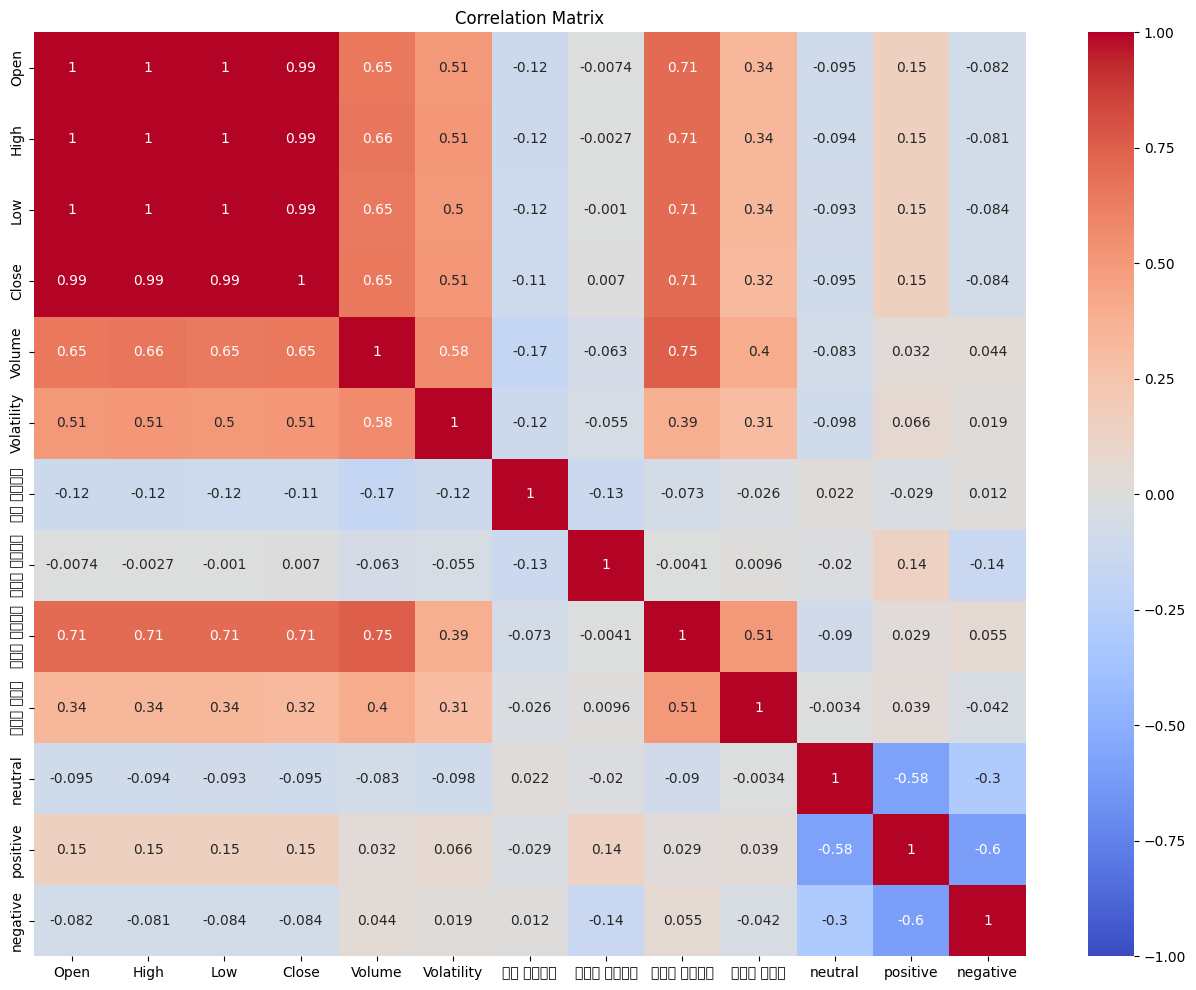

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# 상관관계 계산
correlation_matrix = scaled_df.corr()

plt.figure(figsize=(16, 12))

# 히트맵 시각화
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

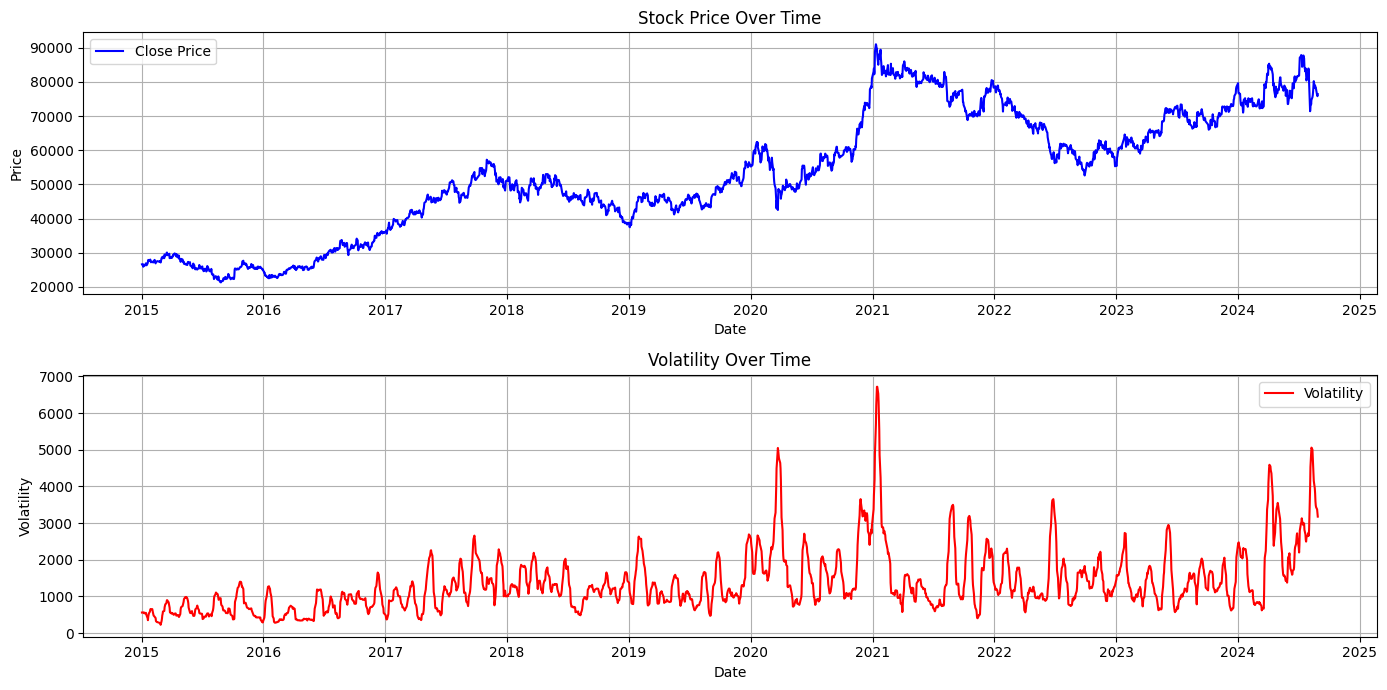

In [29]:
# 시각화
plt.figure(figsize=(14, 7))

# 주가와 변동성의 시계열 그래프를 그립니다.
plt.subplot(2, 1, 1)
plt.plot(df.index, df['Close'], label='Close Price', color='blue')
plt.title('Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(df.index, df['Volatility'], label='Volatility', color='red')
plt.title('Volatility Over Time')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 3. 모델 훈련

In [30]:
def windowed_dataset(series, window_size, batch_size, shuffle):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  if shuffle:
    ds = ds.shuffle(1000)
  ds = ds.map(lambda w: (w[:-1], w[-1]))
  return ds.batch(batch_size).prefetch(1)

In [31]:
# 모델에 들어갈 변수값들
WINDOW_SIZE = 20
BATCH_SIZE = 32

In [32]:
def train_model(data):
  # ====================== STEP 1. train, test 데이터 정의 ======================
  global WINDOW_SIZE, BATCH_SIZE

  train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
  test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

  # ============================= STEP 2. 모델 정의 =============================
  from tensorflow.keras.models import Sequential
  from tensorflow.keras.layers import Dense, LSTM, Conv1D ,Dropout, Lambda,Bidirectional, BatchNormalization
  from tensorflow.keras.losses import Huber
  from tensorflow.keras.optimizers import Adam
  from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


  model = Sequential([
      # Conv1D 레이어
      Conv1D(filters=64, kernel_size=5,
            padding="causal",
            activation="relu",
            input_shape=[WINDOW_SIZE, 1]),

      # 양방향 LSTM 레이어
      Bidirectional(LSTM(64, activation='tanh', return_sequences=False)),

      # Dropout 레이어
      Dropout(0.1),

      # Dense 레이어 (뉴런 수 증가, 배치 정규화 추가)
      Dense(25, activation='relu', name = "..."),

      # 출력 레이어
      Dense(1),
  ])

  # ============================= STEP 3. 모델 훈련 설정 =============================
  import os
  loss = Huber()
  optimizer = Adam(0.005)

  model.compile(loss=Huber(), optimizer = optimizer, metrics = ['mse'])

  # earlystopping
  earlystopping = EarlyStopping(monitor = 'val_loss', patience = 10)

  # val_loss 기준 체크포인터도 생성
  filename = os.path.join('tmp', 'checkpointer.weights.h5')
  checkpoint = ModelCheckpoint(filename,
                              save_weights_only = True,
                              save_best_only=True,
                              monitor='val_loss',
                              verbose=1)

  # ============================= STEP 4. 모델 학습 =============================
  # model fitting
  print('model1 training.....')
  history = model.fit(train_data,
                       validation_data=(test_data),
                       epochs=50,
                       callbacks=[checkpoint, earlystopping])
  model.load_weights(filename)
  pred = model.predict(test_data)


  return model, pred

In [33]:
# 모델 학습 후 변수에 저장
import numpy as np
_, pred = train_model(scaled_df)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


model1 training.....
Epoch 1/50
     59/Unknown 6s 7ms/step - loss: 0.0061 - mse: 0.0123

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 1: val_loss improved from inf to 0.00171, saving model to tmp/checkpointer.weights.h5
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0061 - mse: 0.0121 - val_loss: 0.0017 - val_mse: 0.0034
Epoch 2/50
56/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.1996e-04 - mse: 0.0014
Epoch 2: val_loss did not improve from 0.00171
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.4040e-04 - mse: 0.0015 - val_loss: 0.0030 - val_mse: 0.0060
Epoch 3/50
55/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.8270e-04 - mse: 0.0012
Epoch 3: val_loss improved from 0.00171 to 0.00039, saving model to tmp/checkpointer.weights.h5
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.8476e-04 - mse: 0.0012 - val_loss: 3.9485e-04 - val_mse: 7.8971e-04
Epoch 4/50
56/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.3868e-04 - mse: 6.7735e-04
Epoch 4: val_loss did not improve from 0.00039
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.4381e-04 - mse: 6.8763e-04 - val_loss: 5.3402e-04 - val_mse: 0.0011
Epoch 5/50
56/5

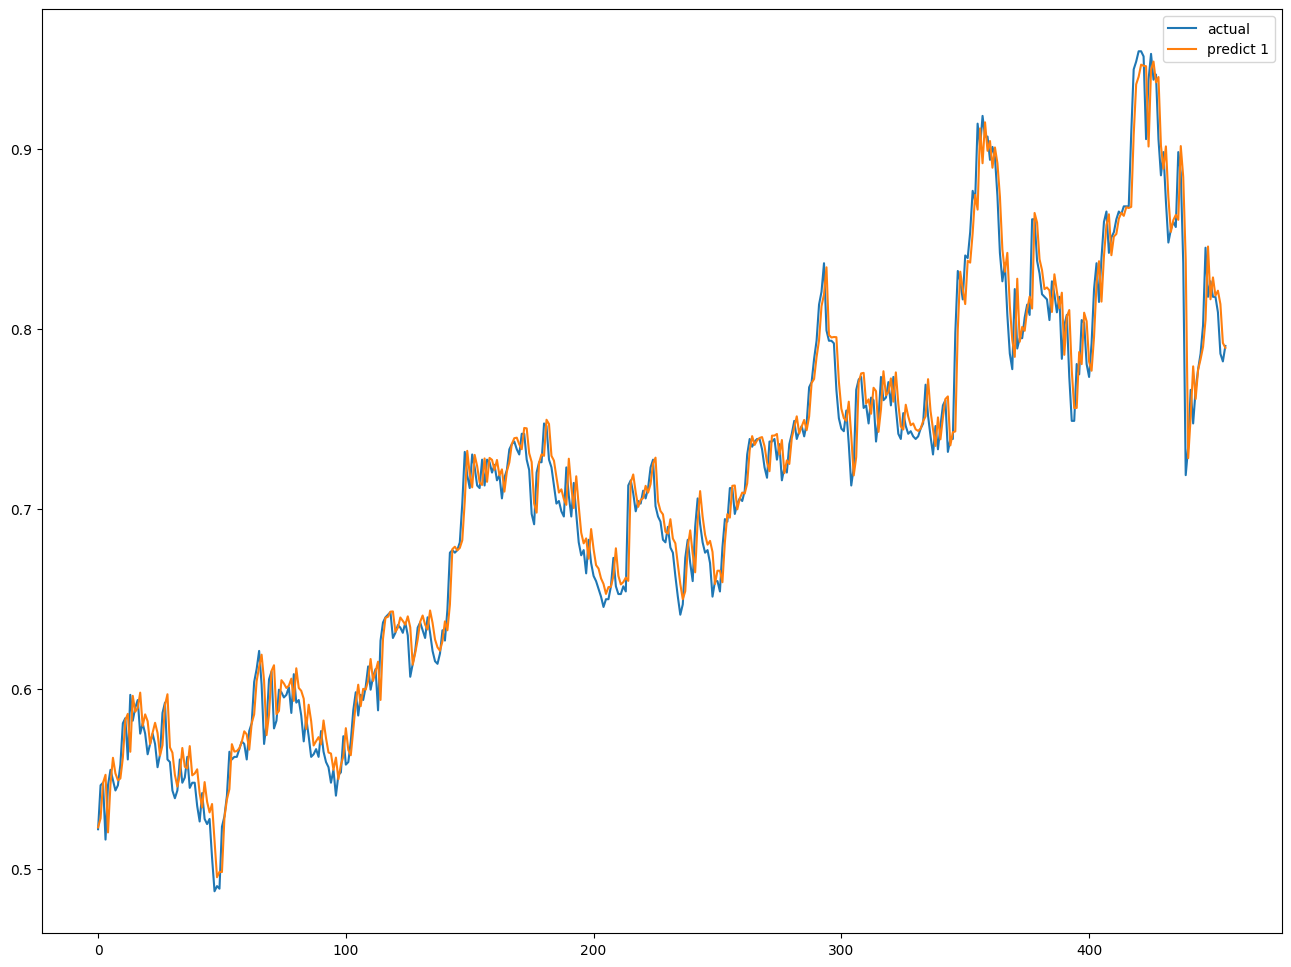

In [34]:
# 예측데이터 시각화
plt.figure(figsize=(16, 12))
plt.plot(np.asarray(y_test)[WINDOW_SIZE:], label='actual')
plt.plot(pred, label='predict 1')
plt.legend()
plt.show()

In [35]:
# 성능 확인
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test[WINDOW_SIZE:], pred)
print('\n-------------------------\nMSE :', np.sqrt(mse), '\n-------------------------')


-------------------------
MSE : 0.01672126559960262 
-------------------------


In [36]:
# 스케일링 복구
expanded_pred_values = np.zeros((pred.size, df.shape[1]))
expanded_pred_values[:, 0] = pred[:, 0]

original_scale_values = scaler.inverse_transform(expanded_pred_values)
prediction = original_scale_values[:, 0]

# prediction[-1]은 다음날 예측 가격
print('Model 1 - 8월 29일 종가: ',prediction[-1])
print(df.columns)

Model 1 - 8월 29일 종가:  71278.67395877838
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Volatility', '기관 순매매량',
       '외국인 순매매량', '외국인 보유주수', '외국인 보유율', 'neutral', 'positive', 'negative'],
      dtype='object')
